CDL Exploration (Nebraska)

Memory-safe CDL checks for Nebraska: per-year corn coverage, downsampled stable-corn mask, and AOI footprint. GPU is used where it helps; disk I/O dominates the per-block counting.

In [1]:
import sys, pathlib, os
from dotenv import load_dotenv

repo_root = pathlib.Path.cwd().resolve().parent if (pathlib.Path.cwd().name == 'notebooks') else pathlib.Path.cwd().resolve()
sys.path.append(str(repo_root))
load_dotenv(repo_root / '.env')
print('Repo root:', repo_root)
print('GPU_ENABLED:', os.getenv('GPU_ENABLED'))


Repo root: /home/henry/dev/nitrogen-features
GPU_ENABLED: true


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from rasterio.crs import CRS
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds, transform as warp_coords
from rasterio.transform import Affine, rowcol
from shapely.geometry import box
import geopandas as gpd
import torch
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.patches import Patch, Rectangle
from matplotlib import patheffects as pe
from pathlib import Path

from src.config import CDL_DIR, GPU_ENABLED
from src.datasources.cdl_loader import load_cdl_year
from src.geo.aoi_nebraska import NEBRASKA_BBOX

CORN_CLASS = 1  # CDL corn class id
SOYBEAN_CLASS = 5  # CDL soybean class id
YEARS = [2019, 2020, 2021, 2022, 2023, 2024]
DOWNSAMPLE = 3  # downsample factor for previews (30m * 3 = 90m pixels)
AOI_FOR_STATS = NEBRASKA_BBOX  # clip heavy ops to the Nebraska footprint
CITIES = {
    "Omaha": (-95.997, 41.2565),
    "Lincoln": (-96.685, 40.8136),
}
STATE_SHP = Path(CDL_DIR).parent / "us_states_5m/cb_2022_us_state_5m.shp"
STATE_NAMES_FOR_CONTEXT = ["Nebraska"]
DEVICE = "cuda" if (GPU_ENABLED and torch.cuda.is_available()) else "cpu"
if GPU_ENABLED and not torch.cuda.is_available():
    raise RuntimeError("GPU_ENABLED=true but CUDA not available; set GPU_ENABLED=false or install CUDA-enabled torch")
print("Using device:", DEVICE)


def waypoint_pixels(transform, crs, data_shape, cities=CITIES):
    """Project city lon/lat to pixel space for annotation."""
    lons, lats = zip(*cities.values())
    xs, ys = warp_coords("EPSG:4326", crs, lons, lats)
    coords = []
    for (name, x, y) in zip(cities.keys(), xs, ys):
        row, col = rowcol(transform, x, y)
        if 0 <= col < data_shape[1] and 0 <= row < data_shape[0]:
            coords.append((name, col, row))
    return coords


def plot_city_waypoints(ax, transform, crs, data_shape, size=16, dx=6, dy=-6, text_size=7, stroke=1.2):
    """Overlay city markers/labels for orientation."""
    coords = waypoint_pixels(transform, crs, data_shape)
    for name, col, row in coords:
        ax.scatter(col, row, s=size, c="white", edgecolor="black", linewidth=1.1, zorder=5)
        ax.text(
            col + dx,
            row + dy,
            name,
            color="white",
            fontsize=text_size,
            fontweight="bold",
            va="center",
            ha="left",
            path_effects=[pe.withStroke(linewidth=stroke, foreground="black")],
            zorder=6,
        )


def load_state_boundaries(target_crs, states=STATE_NAMES_FOR_CONTEXT):
    if not STATE_SHP.exists():
        raise FileNotFoundError(f"State shapefile not found: {STATE_SHP}")
    gdf = gpd.read_file(STATE_SHP)
    if states:
        gdf = gdf[gdf["NAME"].isin(states)]
    return gdf.to_crs(target_crs).geometry


def plot_state_boundaries(ax, geoms, transform, color="#bbbbbb", lw=0.6, alpha=0.7):
    """Plot thin, subtle state boundaries in pixel space on an existing imshow axis."""
    for geom in geoms:
        if geom.is_empty:
            continue
        parts = geom.geoms if hasattr(geom, "geoms") else [geom]
        for part in parts:
            if part.is_empty:
                continue
            x, y = part.exterior.xy
            rows, cols = rowcol(transform, x, y)
            ax.plot(cols, rows, color=color, linewidth=lw, alpha=alpha, zorder=4)


Using device: cuda


Per-year corn coverage (streamed)
- Streams CDL blocks to avoid loading multi-GB rasters.
- GPU is used for per-block equality/count if available; still largely disk-bound.
- Reports corn pixels, % of AOI, and km² (30 m pixels → 900 m²).

In [3]:

def count_corn(year, corn_class=CORN_CLASS, aoi=AOI_FOR_STATS):
    """
    Count corn pixels in a CDL raster within an AOI.
    Uses GPU for equality/count if DEVICE == "cuda".
    Returns: corn_count (int), total_pixels (int)
    """
    data, _, _ = load_cdl_year(year, aoi=aoi)
    if DEVICE == "cuda":
        t = torch.as_tensor(data, device=DEVICE)
        corn_count = (t == corn_class).sum().item()
        total = t.numel()
    else:
        corn_count = (data == corn_class).sum()
        total = data.size
    return corn_count, total


stats = []
for y in YEARS:
    corn_count, total = count_corn(y)
    pct = corn_count / total * 100
    area_km2 = corn_count * 900 / 1e6  # 30m pixels -> 900 m^2
    stats.append((y, corn_count, pct, area_km2))

print(f"Per-year corn coverage in AOI {AOI_FOR_STATS} (corn pixels, % of AOI, km^2 assuming 30m pixels):")
for y, cnt, pct, area in stats:
    print(f"{y}: corn pixels={cnt:,} ({pct:.2f}%), ~{area:.1f} km^2")


Per-year corn coverage in AOI (-104.05, 40.0, -95.31, 43.0) (corn pixels, % of AOI, km^2 assuming 30m pixels):
2019: corn pixels=64,153,196 (21.51%), ~57737.9 km^2
2020: corn pixels=65,627,009 (22.00%), ~59064.3 km^2
2021: corn pixels=64,012,743 (21.46%), ~57611.5 km^2
2022: corn pixels=62,643,206 (21.00%), ~56378.9 km^2
2023: corn pixels=64,354,409 (21.58%), ~57919.0 km^2
2024: corn pixels=63,307,670 (21.22%), ~56976.9 km^2


Downsampled stable-corn mask
- Resample each year to a coarser grid (factor = DOWNSAMPLE) and compute intersection.
- Shows where corn is stable across all selected years; good sanity check for leakage-free tiling.

Stable corn (downsampled 3x): 749,819 pixels (2.26%), ~6073.5 km^2


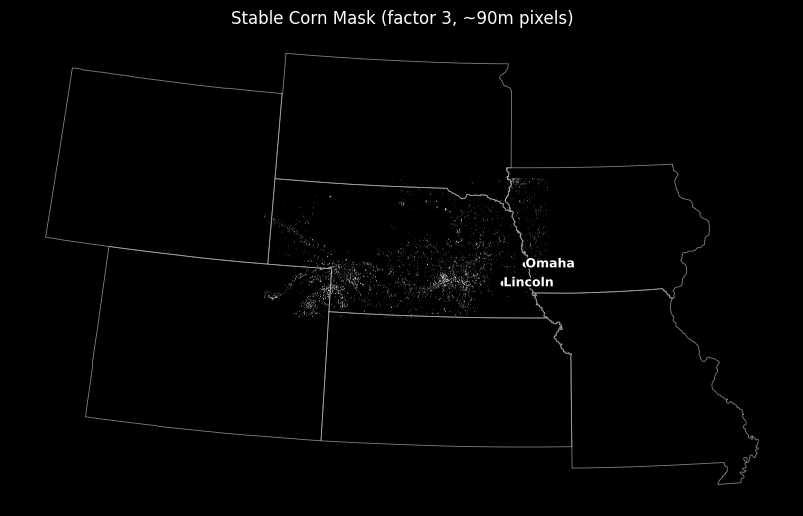

In [4]:

def compute_window_and_shape(factor=DOWNSAMPLE, aoi=AOI_FOR_STATS):
    with rasterio.open(CDL_DIR / f"cdl_NE_{YEARS[0]}.tif") as base:
        if aoi is not None:
            bounds_proj = transform_bounds(CRS.from_epsg(4326), base.crs, *aoi, densify_pts=21)
            window = from_bounds(*bounds_proj, transform=base.transform)
        else:
            window = None
        base_h = window.height if window else base.height
        base_w = window.width if window else base.width
        out_h = int(np.ceil(base_h / factor))
        out_w = int(np.ceil(base_w / factor))
        base_transform = base.window_transform(window) if window else base.transform
        scale_x = base_w / out_w
        scale_y = base_h / out_h
        out_transform = base_transform * Affine.scale(scale_x, scale_y)
        out_crs = base.crs
    return window, out_h, out_w, out_transform, out_crs


def build_stable_mask_downsample(years, factor=DOWNSAMPLE, corn_class=CORN_CLASS, aoi=AOI_FOR_STATS):
    window, out_h, out_w, out_transform, out_crs = compute_window_and_shape(factor=factor, aoi=aoi)
    stable = None
    for y in years:
        with rasterio.open(CDL_DIR / f"cdl_NE_{y}.tif") as src:
            data = src.read(
                1,
                window=window,
                out_shape=(out_h, out_w),
                resampling=Resampling.nearest,
            )
            mask = data == corn_class
            stable = mask if stable is None else (stable & mask)
    return stable, out_transform, out_crs


stable_mask_ds, stable_transform, stable_crs = build_stable_mask_downsample(YEARS)
stable_count = stable_mask_ds.sum()
stable_pct = stable_count / stable_mask_ds.size * 100
stable_area_km2 = stable_count * 900 * (DOWNSAMPLE ** 2) / 1e6
print(f"Stable corn (downsampled {DOWNSAMPLE}x): {stable_count:,} pixels ({stable_pct:.2f}%), ~{stable_area_km2:.1f} km^2")

states_for_stable = load_state_boundaries(stable_crs)

fig, ax = plt.subplots(figsize=(8, 8))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")
ax.imshow(stable_mask_ds, cmap="gray")
plot_state_boundaries(ax, states_for_stable, stable_transform)
plot_city_waypoints(ax, stable_transform, stable_crs, stable_mask_ds.shape)
ax.set_title(f"Stable Corn Mask (factor {DOWNSAMPLE}, ~{30*DOWNSAMPLE}m pixels)", color="white")
ax.axis("off")
fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.show()


Corn masks by year (downsampled previews)

Downsampled visuals (factor = DOWNSAMPLE) to spot spatial inconsistencies without loading full resolution.

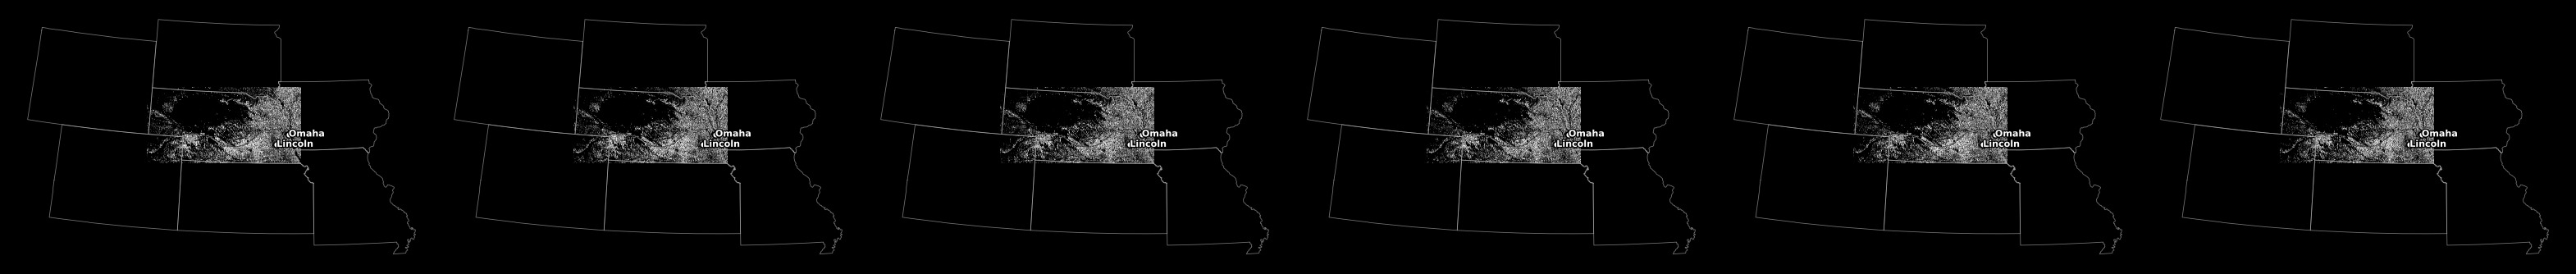

In [5]:

window, out_h, out_w, out_transform, out_crs = compute_window_and_shape(DOWNSAMPLE, AOI_FOR_STATS)
states_for_preview = load_state_boundaries(out_crs)

fig, axes = plt.subplots(1, len(YEARS), figsize=(5.2 * len(YEARS), 5.4), constrained_layout=False)
fig.patch.set_facecolor("black")
for i, y in enumerate(YEARS):
    with rasterio.open(CDL_DIR / f"cdl_NE_{y}.tif") as src:
        data = src.read(1, window=window, out_shape=(out_h, out_w), resampling=Resampling.nearest)
        corn_mask = data == CORN_CLASS
        ax = axes[i]
        ax.set_facecolor("black")
        ax.imshow(corn_mask, cmap="gray")
        plot_state_boundaries(ax, states_for_preview, out_transform, lw=0.6, alpha=0.6)
        plot_city_waypoints(ax, out_transform, out_crs, corn_mask.shape, size=18, dx=6, dy=-7, text_size=7, stroke=1.2)
        ax.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()


Corn vs soybean map (CDL)

A small AOI preview styled like the Nature figure: CDL pixels are re-colored into corn/soy/other/not-enough-data buckets with a scale bar and legend. Adjust `AOI_FOR_VIZ` or `VIS_YEAR` to explore other parts of Nebraska.

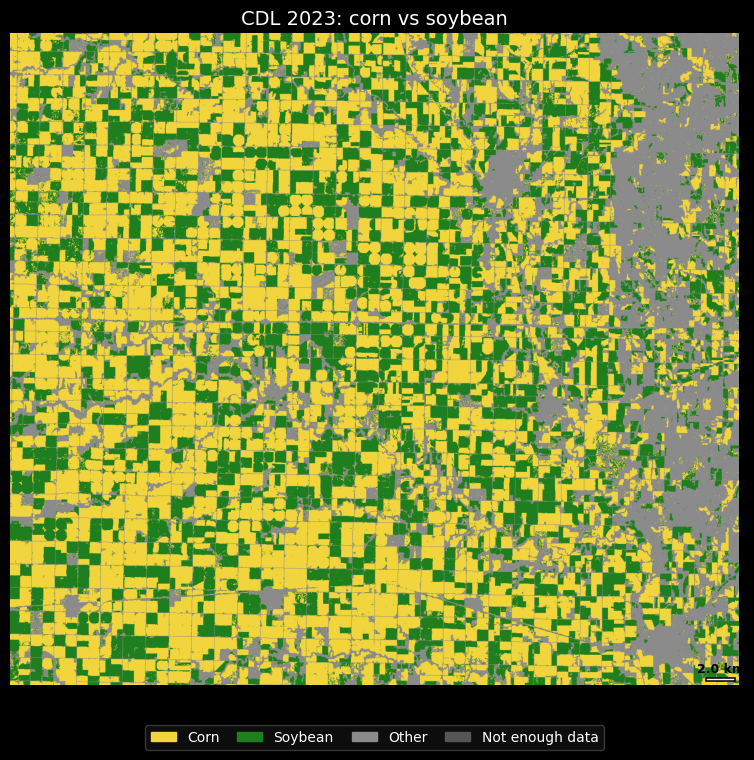

In [6]:

AOI_FOR_VIZ = (-97.5, 40.6, -96.9, 41.0)  # (~Lincoln area; lon/lat WGS84)
VIS_YEAR = 2023

cdl_palette = ["#f2d53d", "#1f7f1f", "#8b8b8b", "#555555"]
cdl_labels = ["Corn", "Soybean", "Other", "Not enough data"]
cmap = ListedColormap(cdl_palette, name="corn_soy_other")
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)


def reclass_cdl(data, corn_class=CORN_CLASS, soybean_class=SOYBEAN_CLASS):
    classes = np.full(data.shape, 2, dtype=np.uint8)  # other by default
    classes[data == corn_class] = 0
    classes[data == soybean_class] = 1
    classes[data == 0] = 3
    return classes


def add_scalebar(ax, transform, data_shape, size_km=2, pad_px=10, height_px=8):
    meters_per_px = abs(transform.a)
    bar_px = size_km * 1000 / meters_per_px
    max_width = data_shape[1] - 2 * pad_px
    if bar_px > max_width:
        bar_px = max_width
        size_km = bar_px * meters_per_px / 1000
    x0 = data_shape[1] - pad_px - bar_px
    y0 = data_shape[0] - pad_px - height_px
    rect = Rectangle((x0, y0), bar_px, height_px, facecolor="white", edgecolor="black", linewidth=1.1)
    ax.add_patch(rect)
    ax.text(
        x0 + bar_px / 2,
        y0 - 4,
        f"{size_km:.1f} km",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
        color="black",
    )


cdl_data, cdl_transform, cdl_crs = load_cdl_year(VIS_YEAR, aoi=AOI_FOR_VIZ)
cdl_classes = reclass_cdl(cdl_data)
states_for_viz = load_state_boundaries(cdl_crs)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")
ax.imshow(cdl_classes, cmap=cmap, norm=norm)
plot_state_boundaries(ax, states_for_viz, cdl_transform)
plot_city_waypoints(ax, cdl_transform, cdl_crs, cdl_classes.shape, size=18, dx=6, dy=-7, text_size=7, stroke=1.2)
ax.set_title(f"CDL {VIS_YEAR}: corn vs soybean", fontsize=14, color="white")
ax.set_xlim(0, cdl_classes.shape[1])
ax.set_ylim(cdl_classes.shape[0], 0)
ax.axis("off")

add_scalebar(ax, cdl_transform, cdl_classes.shape, size_km=2)

legend_handles = [Patch(color=cdl_palette[i], label=cdl_labels[i]) for i in range(len(cdl_labels))]
leg = ax.legend(
    handles=legend_handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=4,
    frameon=True,
    columnspacing=1.3,
    handlelength=1.8,
)
leg.get_frame().set_facecolor("#111111")
leg.get_frame().set_edgecolor("#444444")
for txt in leg.get_texts():
    txt.set_color("white")
fig.subplots_adjust(bottom=0.12, left=0.01, right=0.99, top=0.99)

plt.show()


AOI footprint

Bounding box for the Nebraska study area (WGS84).

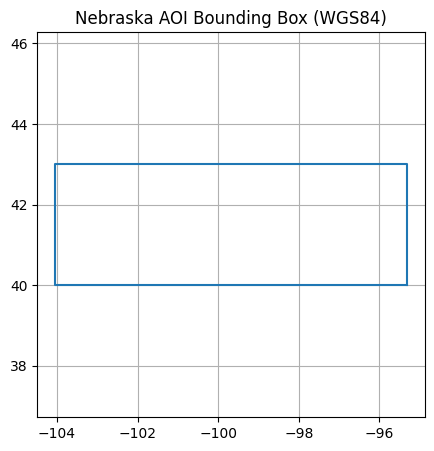

In [7]:
poly = box(*NEBRASKA_BBOX)
x, y = poly.exterior.xy
plt.figure(figsize=(5, 5))
plt.plot(x, y)
plt.title("Nebraska AOI Bounding Box (WGS84)")
plt.axis("equal")
plt.grid(True)
plt.show()


Notes
- Run cells in order; the imports/constants cell defines CORN_CLASS, DEVICE, etc.
- GPU helps for model training; this notebook is I/O-bound, so GPU acceleration on counts is minimal.
- If imports fail, ensure kernel is `.venv/bin/python` and run `%pip install -r requirements.txt`.